# Análisis de Restaurantes en CDMX

In [1]:
%load_ext autoreload
%autoreload 1

import sys
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import dash
from dash import dcc, html, Input, Output
import plotly.express as px

project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")

if src_path not in sys.path:
    sys.path.append(src_path)

from equipo_7 import (DataViz, detect_outliers_iqr, transform_outliers,
    get_varclushi, get_pca, get_kbest, get_information_value)

pd.set_option('display.max_columns', None)


def count_percentage(df, columna):
    # Realizar el conteo de valores en la columna especificada
    conteo = df[columna].value_counts().reset_index()
    conteo.columns = [columna, 'conteo']
    
    # Calcular los porcentajes
    total = conteo['conteo'].sum()
    conteo['porcentaje'] = round((conteo['conteo'] / total) * 100, 2)
    
    return conteo


def preview_data(data, id_column):

    print("> Total de registros: ", len(data))
    
    # Eliminar duplicados
    data_no_duplicates = len(data.drop_duplicates())
    unique_ids = len(data[id_column].unique())
    
    print("> Total de registros (sin duplicados): ", data_no_duplicates)
    print("> Cantidad de ids unicos: ", unique_ids)
    display(data.head(1))


def create_feature_dataframe(data, column):
    feature = data.columns[0]
    category = data.at[0, column]
    conteo = data.at[0, 'conteo']
    porcentaje = data.at[0, 'porcentaje']
    
    # Constructing the final dictionary
    variable = {
        'feature': feature, 
        'category': category,
        'conteo': conteo,
        'porcentaje': porcentaje
    }
    
    # Converting the dictionary to a DataFrame
    return pd.DataFrame([variable])

# Análisis preeliminar de la información

## Usuarios

### Users
La tabla concentra información resumida del usuario. 

In [2]:
users_df = pd.read_csv("../data/Restaurante/users.csv")
preview_data(users_df, "userID")

> Total de registros:  138
> Total de registros (sin duplicados):  138
> Cantidad de ids unicos:  138


,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77


### User cuisine
La tabla registra los tipos de cocina predilectas por el usuario. 

In [3]:
user_cuisine_df = pd.read_csv("../data/Restaurante/usercuisine.csv")
preview_data(user_cuisine_df, "userID")

> Total de registros:  330
> Total de registros (sin duplicados):  330
> Cantidad de ids unicos:  138


,userID,Rcuisine
0,U1001,American


In [4]:
count_percentage(user_cuisine_df, "Rcuisine")

,Rcuisine,conteo,porcentaje
0,Mexican,97,29.39
1,American,11,3.33
2,Cafeteria,9,2.73
3,Pizzeria,9,2.73
4,Cafe-Coffee_Shop,8,2.42
...,...,...,...
98,Persian,1,0.30
99,Ethiopian,1,0.30
100,Romanian,1,0.30
101,Cambodian,1,0.30


### Userpayment
Registra los métodos de pago con los que cuenta el usuario

In [5]:
user_payment_df = pd.read_csv("../data/Restaurante/userpayment.csv")
preview_data(user_payment_df, "userID")

> Total de registros:  177
> Total de registros (sin duplicados):  177
> Cantidad de ids unicos:  133


,userID,Upayment
0,U1001,cash


In [6]:
count_percentage(user_payment_df, "Upayment")

,Upayment,conteo,porcentaje
0,cash,131,74.01
1,bank_debit_cards,22,12.43
2,VISA,17,9.60
3,MasterCard-Eurocard,4,2.26
4,American_Express,3,1.69


## Restaurantes

### Restaurants
Registra la información resumida de los restaurantes. 

In [7]:
restaurants_df = pd.read_csv("../data/Restaurante/restaurants.csv")
preview_data(restaurants_df, "placeID")

> Total de registros:  130
> Total de registros (sin duplicados):  130
> Cantidad de ids unicos:  130


,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,?,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none


In [8]:
count_percentage(restaurants_df, "alcohol")

,alcohol,conteo,porcentaje
0,No_Alcohol_Served,87,66.92
1,Wine-Beer,34,26.15
2,Full_Bar,9,6.92


### Cuisine
Indica los tipos de cocina ofertados por el restaurante. 


In [9]:
# Un restaurante puede tener más de un tipo de cocina (Rcuisine)
cuisine_df = pd.read_csv("../data/Restaurante/cuisine.csv")
preview_data(cuisine_df, "placeID")

> Total de registros:  916
> Total de registros (sin duplicados):  916
> Cantidad de ids unicos:  769


,placeID,Rcuisine
0,135110,Spanish


### Hours
Registra los días y horarios en los que el restaurante ofrece servicios

In [10]:
# Un restaurante puede tener más de un registro 
# ya que maneja diferentes horarios para días entre semana, 
# y fines de semana
hours_df = pd.read_csv("../data/Restaurante/hours.csv")
preview_data(hours_df, "placeID")

> Total de registros:  2339
> Total de registros (sin duplicados):  2068
> Cantidad de ids unicos:  694


,placeID,hours,days
0,135111,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;


In [11]:
DataViz.completitud(hours_df)

,Total de nulos,% valores nulos
placeID,0,0.0
hours,0,0.0
days,0,0.0


In [12]:
count_percentage(hours_df, "days")

,days,conteo,porcentaje
0,Mon;Tue;Wed;Thu;Fri;,793,33.90
1,Sat;,783,33.48
2,Sun;,763,32.62


### Parking
Registra los tipos de estacionamiento a los que tiene acceso el restaurante. 

In [13]:
parking_df = pd.read_csv("../data/Restaurante/parking.csv")
preview_data(parking_df, "placeID")

> Total de registros:  702
> Total de registros (sin duplicados):  702
> Cantidad de ids unicos:  675


,placeID,parking_lot
0,135111,public


In [14]:
count_percentage(parking_df, "parking_lot")

,parking_lot,conteo,porcentaje
0,none,348,49.57
1,yes,174,24.79
2,public,102,14.53
3,street,32,4.56
4,fee,22,3.13
5,valet parking,21,2.99
6,validated parking,3,0.43


### Paymenth methods
Muestra las formas de pago con las que cuentan los restaurantes. 

In [15]:
payment_methods_df = pd.read_csv("../data/Restaurante/payment_methods.csv")
preview_data(payment_methods_df, "placeID")

> Total de registros:  1314
> Total de registros (sin duplicados):  1314
> Cantidad de ids unicos:  615


,placeID,Rpayment
0,135110,cash


## Dataset Usuarios

In [16]:
users_merged_df = (
    users_df.merge(user_cuisine_df, on="userID", how="left")
            .merge(user_payment_df, on="userID", how="left")
)

users_merged_df = users_merged_df.replace("?", np.nan).replace("none", np.nan)

preview_data(users_merged_df, "userID")

> Total de registros:  416
> Total de registros (sin duplicados):  416
> Cantidad de ids unicos:  138


,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,Rcuisine,Upayment
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,NaN,student,black,69,medium,1.77,American,cash


## Dataset Restaurantes

In [18]:
restaurants_merged_df = (
    restaurants_df.merge(parking_df, on="placeID", how="left")
                  .merge(hours_df, on="placeID", how="left")
                  .merge(cuisine_df, on="placeID", how="left")
                  .merge(payment_methods_df, on="placeID", how="left")
)

restaurants_merged_df = restaurants_merged_df.replace("?", np.nan).replace("none", np.nan)
preview_data(restaurants_merged_df, "placeID")

> Total de registros:  901
> Total de registros (sin duplicados):  901
> Cantidad de ids unicos:  130


/tmp/ipykernel_47626/4194371838.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  restaurants_merged_df = restaurants_merged_df.replace("?", np.nan).replace("none", np.nan)


,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services,parking_lot,hours,days,Rcuisine,Rpayment
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,NaN,NaN,No_Alcohol_Served,NaN,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,NaN,NaN,11:00-21:00;,Mon;Tue;Wed;Thu;Fri;,Japanese,NaN


## Dataset Ratings
La tabla registra las calificaciones que el usuario asigna a los restaurantes en diversos rubros. 


In [20]:
rating_df = pd.read_csv("../data/Restaurante/ratings.csv")
rating_df = rating_df.replace("?", np.nan).replace("none", np.nan)
preview_data(rating_df, "userID")

> Total de registros:  1161
> Total de registros (sin duplicados):  1161
> Cantidad de ids unicos:  138


,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2


# Preparación del dataset

## Creación del dataset

In [49]:
# El dataset df contiene la información reunida de los datos
# de los usuarios, los restaurantes y sus calificaciones
df = (
    rating_df.merge(users_merged_df, on="userID", how="left")
             .merge(restaurants_merged_df, on="placeID", how="left")
).drop(columns=["userID", "placeID"])

In [50]:
DataViz.completitud(df)

,Total de nulos,% valores nulos
rating,0,0.00
food_rating,0,0.00
service_rating,0,0.00
latitude_x,0,0.00
longitude_x,0,0.00
smoker,237,0.75
drink_level,0,0.00
dress_preference,456,1.44
ambience,438,1.39
transport,375,1.19


## Limpieza de los datos

In [23]:
# Identificando variables númericas y categóricas
# Variables númericas: imputar con la mediana
variables_numericas = df.select_dtypes(include=['number']).columns

# Variables categóricas: imputar con la moda
variables_categoricas = df.select_dtypes(include=['object']).columns

#### Detección y remoción de valores extremos

In [24]:
for c in variables_numericas:
    lower_bound, upper_bound = detect_outliers_iqr(df, c)
    df = transform_outliers(df, c, lower_bound, upper_bound)

/workspace/src/equipo_7.py:253: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '49.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data[column] < lower_bound, column] = lower_bound


#### Detección y remoción de variables poco pobladas
para valores con cantidad de valores nulos > 65%

In [25]:
completitud_df = DataViz.completitud(df)
completitud_df[completitud_df["% valores nulos"] >= 65]

,Total de nulos,% valores nulos
fax,31559,100.00
url,24723,78.34
other_services,30464,96.53


De acuerdo al umbral definido de 65%, las features a eliminar son: fax, url y ohter_services

In [26]:
df = df.drop(columns=["fax", "url", "other_services"])
# Actualizando las variables
variables_numericas = df.select_dtypes(include=['number']).columns
variables_categoricas = df.select_dtypes(include=['object']).columns

#### Detección y tratamiento de valores ausentes.

In [27]:
for col in variables_numericas:
    media = df[col].median()
    df.loc[:, col] = df[col].fillna(media)  

for col in variables_categoricas:
    moda = df[col].mode()[0]
    df.loc[:, col] = df[col].fillna(moda)

#### Remoción de variables altamente correlacionadas
valores con correlación 1 en valor absoluto

In [28]:
df[variables_numericas].corr()

,rating,food_rating,service_rating,latitude_x,longitude_x,birth_year,weight,height,latitude_y,longitude_y
rating,1.000000,0.863736,0.851588,-0.428911,-0.050935,-0.271160,-0.059870,0.432180,-0.137236,-0.018026
food_rating,0.863736,1.000000,0.813542,-0.428333,-0.033502,-0.290543,-0.054486,0.400693,-0.186159,-0.059249
service_rating,0.851588,0.813542,1.000000,-0.399821,0.008346,-0.256271,-0.087250,0.340191,-0.080551,0.047637
latitude_x,-0.428911,-0.428333,-0.399821,1.000000,-0.260028,0.515883,0.207733,-0.110040,0.519499,0.022518
longitude_x,-0.050935,-0.033502,0.008346,-0.260028,1.000000,-0.164105,-0.228945,-0.318652,-0.102350,0.483821
birth_year,-0.271160,-0.290543,-0.256271,0.515883,-0.164105,1.000000,0.122671,-0.009738,0.095447,0.233112
weight,-0.059870,-0.054486,-0.087250,0.207733,-0.228945,0.122671,1.000000,0.499886,0.018206,-0.014029
height,0.432180,0.400693,0.340191,-0.110040,-0.318652,-0.009738,0.499886,1.000000,-0.123897,-0.109321
latitude_y,-0.137236,-0.186159,-0.080551,0.519499,-0.102350,0.095447,0.018206,-0.123897,1.000000,-0.068881
longitude_y,-0.018026,-0.059249,0.047637,0.022518,0.483821,0.233112,-0.014029,-0.109321,-0.068881,1.000000


En el dataset no existen variables altamente correlacionadas

#### Detección y remoción de variables unitarias (unarias)
cuando el 90% de la información se agrupe dentro una sola variable

In [29]:
dfs_list = [ ]
for c in df.columns:
    tmp_count = count_percentage(df, c)
    
    tmp_df = tmp_count[tmp_count["porcentaje"] >= 90]

    if not tmp_df.empty:
        dfs_list.append(create_feature_dataframe(tmp_df, c))

In [30]:
unit_vars = pd.concat(dfs_list).reset_index(drop=True)
unit_vars

,feature,category,conteo,porcentaje
0,smoker,false,29530,93.57
1,marital_status,single,30490,96.61
2,religion,Catholic,30896,97.90
3,country,Mexico,29948,94.90
4,Rambience,familiar,30887,97.87
5,area,closed,28961,91.77


Las variables unitarias a eliminar son: smoker, marital_status, religion, country, Rambience y area

In [31]:
df = df.drop(columns=unit_vars["feature"].to_list())

## Ingeniería de datos:

Se generarán algunas variables:
1. Usuarios
- Edad: considerando que el dataset es de 2024
- Grupo: Mediante un modelo de clusterización para la segmentación de los usuarios por características: interest, activity & budget
- Se crearán variables dummies de: Upayment & budget 

**Edad**

In [32]:
df["edad"] = 2024 - df["birth_year"]
df["edad"].describe()

count    31559.000000
mean        37.435945
std          4.512105
min         30.000000
25%         35.000000
50%         36.000000
75%         41.000000
max         50.000000
Name: edad, dtype: float64

**Segmentación de usuarios**

In [33]:
features = ["interest", "activity", "budget", "dress_preference"]
cluster_df = pd.get_dummies(df[features], drop_first=True, dtype=int)
# La decisión de elegir 3 clusters está basada en la distribución de las
# frecuencias, es decir, que un grupo no tenga una frecuencia muy alta de datos.
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")
df["group"] = kmeans.fit_predict(cluster_df.values)

count_percentage(df, "group")

,group,conteo,porcentaje
0,1,16019,50.76
1,0,11598,36.75
2,2,3942,12.49


Creando las variables **Dummies** de Upayment & budget

In [34]:
features = [
    "Upayment", "budget", "ambience",
    "transport", "hijos", "dress_preference"
]

dummies_df = pd.get_dummies(df[features], drop_first=True, dtype=int)
df = pd.concat([df, dummies_df], axis=1)

## Construcción de variable Objetivo

La puntuación será la variable target a obtener, basado en los características del cliente y del restaurante. 

Ya que existen 3 calificaciones para un restaurante: general, comida y servicio, se obtendrá un promedio de estás tres

In [35]:
subset = ["rating", "food_rating", "service_rating"]
df["global_rating"] = df[subset].mean(axis=1).round(2)
df = df.drop(columns=subset)
# Renombrando global_rating por rating para facilitar su manejo
df = df.rename(columns={"global_rating": "rating"})

# Reducción de dimensionalidad

In [36]:
subset = [
    "edad",
    "group",
    "Upayment_MasterCard-Eurocard",
    "Upayment_VISA",
    "Upayment_bank_debit_cards",
    "Upayment_cash", 
    "budget_low", "budget_medium",
    "ambience_friends", "ambience_solitary",
    "transport_on foot","transport_public",
    "hijos_independent",
    "hijos_kids", "dress_preference_formal",
     "dress_preference_informal",
     "dress_preference_no preference"
]

minmax = MinMaxScaler()
minmax_df = pd.DataFrame(
    minmax.fit_transform(df[subset]),
    columns=subset
)

target_df = df[["rating"]]

## PCA

In [37]:
pca, pca_df= get_pca(minmax_df, 2)
total_explained_variance = pca.explained_variance_ratio_.cumsum()[-1]

print("Total de varianza explicada: ", total_explained_variance)

Total de varianza explicada:  0.631077687970601


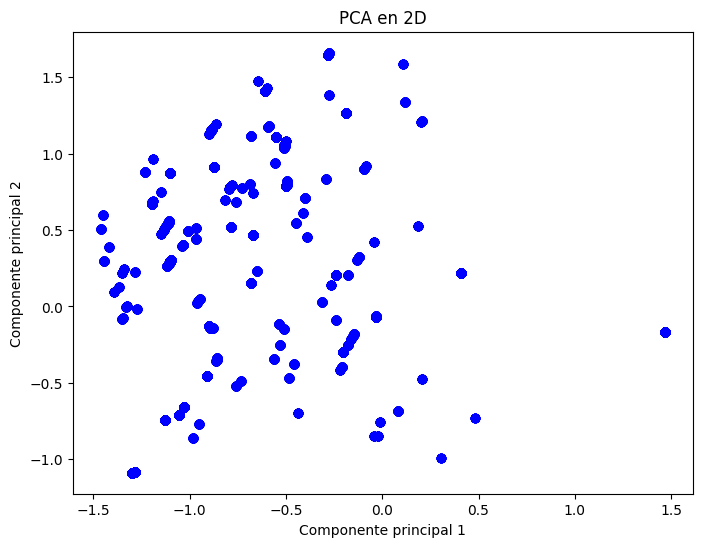

In [38]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Dibujar los puntos en el espacio 3D
ax.scatter(pca_df.loc[:, 0], pca_df.loc[:, 1], c='b', marker='o')

# Añadir etiquetas de los ejes
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
# Mostrar el gráfico
plt.title('PCA en 2D')
plt.show()

## Clustering de variables

In [39]:
vc_df, vc_rsquare_df, best_features = get_varclushi(minmax_df)
best_features.to_frame()

,Variable
Cluster,
0,transport_public
1,group
2,ambience_solitary
3,edad
4,dress_preference_formal
5,Upayment_cash


## Kbest

In [40]:
scores_df = get_kbest(minmax_df, target_df, k=10)
scores_df

,Feature,Score
13,hijos_kids,32112.562422
12,hijos_independent,30498.226520
6,budget_low,25152.593400
7,budget_medium,22804.785814
1,group,16964.423978
10,transport_on foot,14001.104358
11,transport_public,6900.582288
5,Upayment_cash,3333.249006
15,dress_preference_informal,3048.876562
0,edad,2861.811535


In [41]:
df_IV = pd.concat((minmax_df, target_df), axis=1)
df_IV

,edad,group,Upayment_MasterCard-Eurocard,Upayment_VISA,Upayment_bank_debit_cards,Upayment_cash,budget_low,budget_medium,ambience_friends,ambience_solitary,transport_on foot,transport_public,hijos_independent,hijos_kids,dress_preference_formal,dress_preference_informal,dress_preference_no preference,rating
0,0.35,0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
1,0.35,0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
2,0.35,0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
3,0.35,0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
4,0.35,0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31554,0.30,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
31555,0.30,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
31556,0.30,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
31557,0.30,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [42]:
target = "rating"
iv_list = []
for n_bins in range(2, 10):
    for var in minmax_df.columns:
        df_IV[f"C_{var}"] = pd.qcut(df_IV[var], q=n_bins, duplicates="drop").cat.add_categories(["Missing"]).fillna("Missing").astype(str)
    ls_discretized = [x for x in df_IV.columns if x.startswith("C_")]
    df_iv = pd.DataFrame(columns=["iv"])
    for var in ls_discretized:
        df_iv.loc[var, "iv"] = get_information_value(df = df_IV, var = var, tgt = target)
    df_iv['bins'] = n_bins
    iv_list.append(df_iv)

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

In [43]:
iv_df = pd.concat(iv_list, axis= 0)
conteo_iv = iv_df[['bins','iv']].value_counts().to_frame().reset_index()
# Conteo de valores np.inf por cada grupo de bins
conteo_iv[conteo_iv['iv'] == np.inf]

,bins,iv,count


In [44]:
iv_df['iv'].replace([np.inf, -np.inf], np.nan, inplace=True)
promedio_agrupado = iv_df.groupby('bins')['iv'].mean()
# Valor promedio de cada bin para 'IV', donde a un mayor valor, 
# el grupo tiene un mejor desempeño
promedio_agrupado

/tmp/ipykernel_47626/2086812448.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  iv_df['iv'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_47626/2086812448.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  iv_df['iv'].replace([np.inf, -np.inf], np.nan, inplace=True)


bins
2    0.096839
3    0.096839
4    0.480213
5    0.367736
6    0.367736
7    0.480535
8    0.480213
9    0.367736
Name: iv, dtype: float64

In [45]:
threshold = 0.1
best_features = iv_df[(iv_df['bins'] == 4) & (iv_df["iv"] >= threshold)].sort_values('iv', ascending=False)
best_features

,iv,bins
C_edad,8.111332,4


# Dashboard

In [46]:
app = dash.Dash(__name__)

variables_categoricas = df.select_dtypes(include=['object']).columns
valid_columns = (
    variables_categoricas.to_list()
    + ["weight", "height", "edad"]
)

# Definir el diseño del dashboard
app.layout = html.Div(
    style={'textAlign': 'center', 'backgroundColor': '#000000'},
    children=[
        html.H1("Análisis de Restaurantes",
                style={'color': '#ffffff', 'backgroundColor': '#000000'}),
        dcc.Dropdown(
            id='dropdown-column',
            options=[{'label': col, 'value': col} for col in valid_columns],
            value='edad',
            style={'backgroundColor': '#ffffff', 'color': '#000000', 'zIndex': '9999'},  # Fondo blanco y texto negro para el Dropdown
            ),
            html.Div(id='output-chart')
            ]
)

# Definir la lógica de la aplicación Dash
@app.callback(
    Output('output-chart', 'children'),
    [Input('dropdown-column', 'value')]
)
def update_chart(selected_column):
    if selected_column in valid_columns:
        if selected_column in ['weight', 'height', 'age']:
            fig = px.histogram(
                df,
                x=selected_column,
                title=f'Histograma de {selected_column}')
        else:
            grouped_count = df.groupby(selected_column).size().reset_index(name='Count')
            fig = px.bar(grouped_count, x=selected_column, y='Count', title=f'Conteo Agrupado por {selected_column}')
        
        fig.update_layout(
            plot_bgcolor='#000000',  # Fondo negro
            paper_bgcolor='#000000',  # Fondo negro
            font_color='#ffffff'  # Texto blanco
        )
        return dcc.Graph(figure=fig)
    else:
        return html.Div("Seleccione una columna válida para mostrar el gráfico", style={'color': '#ffffff'}) 

In [47]:
app.run_server(mode="inline", host="0.0.0.0", port=8888, use_reloader=True)

[2024-05-20 04:45:08,443] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/flask/app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/site-packages/flask/app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/site-packages/flask/app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/site-packages/flask/app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
  File "/usr/local/lib/python3.10/site-packages/dash/dash.py", line 1373, in dispatch
    ctx.run(
  File "/usr/local/lib/python3.10/site-packages/dash/_callback.py", line 465, in add_context
    output_value = _invoke_callback(func, *func_args, **func_kwargs)
  File "/usr/local/li

# Cuestionario

1. **¿Por qué Excel no es una Base de Datos?** <br>

Excel no es una base de datos porque está diseñado para el análisis y manipulación de datos en hojas de cálculo y  no para gestionar grandes cantidades de datos de forma eficiente.

Las bases de datos están diseñadas para geestinar grandes volúmenes de datos, validar tipos de datos, cuentan con seguridad, además de que tienen un mejor rendimiento. También son resilientes ante la pérdida e informaicón.  <br>

2. **¿Qué diferencia hay entre un Ingeniero de Datos, un Científico de Datos y un Arquitecto de Datos?** <br>

Un ingeniero de datos se encarga de construir y manejar la infraestructura para el manejo de grandes volúmenes de información. Un científico de datos se encarga de extraer la información valiosa, para la toma de decisiones. Y el arquitecto de datos diseña cómo se organizan y estructuran los datos en una empresa.

3. **¿Cómo reduce dimensiones PCA?** <br>

PCA reduce dimensiones encontrando las direcciones en las que los datos varían más y luego proyecta estos datos en las direcciones principales. Con ello se disminuyen las características para representar los datos originales, pero manteniendo la mayor parte de la información importante.

4. **¿Cuál es la diferencia entre importancia de variables y poder predictivo?** <br>

La importancia de variables es una medida de  cuánto contribuye cada variable a la construcción del modelo. El poder predictivo evalúa al modelo en su precisión al realizar predicciones. 